# UCF50


1. DatasetLoader class
2. Model classes
3. Train,Validate functions 
4. Hyperparameters
5. Training the model   (Skip while testing)
6. Testing the model

In [ ]:
#Downloading dataset
#'''
#Trained model https://drive.google.com/file/d/1mP3dFSMMiJwDYlg9wx-M0kHA2h0rkkw0/view?usp=sharing
!wget --no-check-certificate "https://www.crcv.ucf.edu/data/UCF50.rar"
!unrar e UCF50.rar /content/data/videos/
!mkdir /content/data

!wget "https://raw.githubusercontent.com/SumitBamal/videoclassification/master/data/classInd.txt" -O /content/data/classInd.txt
!wget "https://raw.githubusercontent.com/SumitBamal/videoclassification/master/data/testlist.txt" -O /content/data/testlist.txt
!wget "https://raw.githubusercontent.com/SumitBamal/videoclassification/master/data/trainlist.txt" -O /content/data/trainlist.txt
#'''

Streaming output truncated to the last 5000 lines.
Extracting  /content/data/videos/v_HorseRace_g15_c04.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g16_c01.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g16_c02.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g16_c03.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g16_c04.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g16_c05.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g17_c01.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g17_c02.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g17_c03.avi                  23%  OK 
Extracting  /content/data/videos/v_HorseRace_g17_c04.avi                  23%  OK 
Extracting  /content/data/vid

In [ ]:
#imports

from google.colab import drive

import os,sys
import random
import tqdm
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from argparse import ArgumentParser
from torchvision import transforms
import torchvision.models as models



In [ ]:

drive.mount('/content/gdrive')
model_dir_path = '/content/gdrive/My Drive/models_for_testing/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Dataset class and functions
np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)

IMG_SIZE = 256
FRAMES_CNT = 16


def set_frames_cnt(frames_cnt):
    global FRAMES_CNT
    FRAMES_CNT = frames_cnt


def collate_fn(batch):
    videos = torch.stack([img for item in batch for img in random.sample(item[0], k=FRAMES_CNT)])
    labels = [item[1] for item in batch]
    labels = torch.as_tensor(labels)
    return [videos, labels]


def collate_fn_memory(batch):
    videos = torch.stack([img for item in batch for img in item[0]])
    labels = [item[1] for item in batch]
    labels = torch.as_tensor(labels)
    return [videos, labels]


def get_collate_fn(in_memory):
    if in_memory:
        return collate_fn_memory
    else:
        return collate_fn


class VideoDataset(data.Dataset):
    def __init__(self, root, transforms, split="train", in_memory=False, stride=1, frame_cnt=16):
        super(VideoDataset, self).__init__()
        self.root = root
        self.stride = stride
        self.in_memory = in_memory
        self.frame_cnt = frame_cnt
        self.transforms = transforms

        self.classes_file = os.path.join(root, 'classInd.txt')
        self.videos_dir = os.path.join(root, 'videos/')
        if split in ('train', 'val'):
            labels_file = os.path.join(root, 'trainlist.txt')
        else:
            labels_file = os.path.join(root, 'testlist.txt')

        self.videos = []
        self.video_names = []
        self.labels = []
        self.classes = {}
        self.split = split

        with open(self.classes_file, 'rt') as fp:
            for line in fp:
                ind, clas = line.split()
                self.classes[clas] = int(ind) - 1

        with open(labels_file, "rt") as fp:
            for line in tqdm.tqdm(fp, position=0, leave=True):
                file_path = None
                if split in ('train', 'val'):
                    path, ind = line.split()
                    path = path.split('/')[1]
                    file_path = os.path.join(self.videos_dir, path)
                    if (split == 'val' and 'g24' in path or 'g25' in path) or (
                            split == 'train' and not ('g24' in path or 'g25' in path)):
                        self.labels.append(int(ind) - 1)
                    else:
                        continue
                elif split == 'test':
                    clas, path = line.split('/')
                    file_path = os.path.join(self.videos_dir, path.strip())
                    label = self.classes[clas]
                    self.labels.append(label)

                file_path = file_path.strip()
                self.video_names.append(file_path)
                if self.in_memory:
                    self.videos.append(read_video(
                        file_path, transforms=self.transforms, in_memory=in_memory, stride=stride, frame_cnt=frame_cnt))

    def __getitem__(self, idx):
        if self.in_memory:
            images = [self.transforms(item) for item in self.videos[idx]]
        else:
            images = read_video(self.video_names[idx], self.transforms)
        label = self.labels[idx]
        return images, label

    def __len__(self):
        return len(self.video_names)


def read_video(path, transforms=None, in_memory=False, stride=1, frame_cnt=16):
    vidcap = cv2.VideoCapture(path)
    success, image = vidcap.read()
    count = 0
    images = []
    while success:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if transforms and not in_memory:
            image = transforms(image)
        images.append(image)
        success, image = vidcap.read()
        count += 1
    if in_memory:
        stride = min(int(len(images) / frame_cnt), stride)
        starting_point = random.randint(0, len(images) - stride * frame_cnt)
        images = images[starting_point:starting_point + stride * frame_cnt:stride]
    return images

In [ ]:
#Models

class AvgCNNModel(nn.Module):
    def __init__(self, cnn_model, output_size=101, frames_cnt=16):
        super(self.__class__, self).__init__()
        self.output_size = output_size
        self.frames_cnt = frames_cnt
        self.cnn = cnn_model
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, output_size, bias=True)

    def forward(self, videos):
        out = self.cnn(videos)
        out = torch.mean(out.reshape(-1, self.frames_cnt, self.output_size), dim=1)
        return out


class CNNtoRNNModel(nn.Module):
    def __init__(self, cnn_model, output_size=101, frames_cnt=16, drop_rate=0.3, rnn_hid_size=64, rnn_num_layers=1,
                 bidirectional=False):
        super(self.__class__, self).__init__()
        self.frames_cnt = frames_cnt

        self.cnn = cnn_model
        cnn_out_size = self.cnn.fc.in_features
        self.cnn.fc = Identity()

        self.rnn = nn.LSTM(cnn_out_size, rnn_hid_size, rnn_num_layers, bidirectional=bidirectional)
        self.dropout = nn.Dropout(drop_rate)
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(factor * rnn_hid_size, output_size)

    def forward(self, videos):
        b_z, c, h, w = videos.shape
        x = videos.reshape(-1, self.frames_cnt, c, h, w)
        ii = 0
        y = self.cnn((x[:, ii]))
        out, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, self.frames_cnt):
            y = self.cnn((x[:, ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:, -1])
        out = self.fc(out)
        return out


class Identity(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

    def forward(self, x):
        return x

In [ ]:
#train validate predict functions
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for inputs, labels in tqdm.tqdm(loader, total=len(loader), desc="training...", position=0, leave=True):
        videos = inputs.to(device)

        pred_labels = model(videos).cpu()
        loss = loss_fn(pred_labels, labels)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    c=0;accuracy=0
    for inputs, labels in tqdm.tqdm(loader, total=len(loader), desc="validation...", position=0, leave=True):
        c+=1
        correct = 0
    
        videos = inputs.to(device)

        with torch.no_grad():
            pred_labels = model(videos).cpu()
        loss = loss_fn(pred_labels, labels)
        val_loss.append(loss.item())

        predictions = pred_labels.numpy().argmax(axis=1)
        for i,j in zip(predictions,labels):
            if i==j:
                correct+=1
        accuracy+= correct*100/len(predictions)
    print('Accuracy: ',accuracy/c) 

    return np.mean(val_loss)


def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset),))
    labels = np.zeros((len(loader.dataset),))
    for i, (inputs, label) in enumerate(
            tqdm.tqdm(loader, total=len(loader), desc="test prediction...", position=0, leave=True)):
        videos = inputs.to(device)

        with torch.no_grad():
            pred_labels = model(videos).cpu()
        prediction = pred_labels.numpy().argmax(axis=1)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction.reshape(-1)
        labels[i * loader.batch_size: (i + 1) * loader.batch_size] = label
    return predictions, labels

def get_dataloaders(data_path, transformations, batch_size=16, num_workers=1, in_memory=False, stride=2):
    collate_fn = get_collate_fn(in_memory)
    train_dataset = VideoDataset(data_path, transformations, split="train", in_memory=in_memory,
                                 stride=stride)
    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,
                                       pin_memory=True, shuffle=True, drop_last=True, collate_fn=collate_fn)

    val_dataset = VideoDataset(data_path, transformations, split="val", in_memory=in_memory,
                               stride=stride)
    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers,
                                     pin_memory=True, shuffle=False, drop_last=False, collate_fn=collate_fn)
    return train_dataloader, val_dataloader

In [ ]:
#Hyperparameters
cnn_model_ = 'resnet34' #or 'resnet18'
frames_cnt = 16
data_loc = './data'
batch_size = 16
model_type = 'cnn-rnn' #or 'cnn-avg'
name = 'baseline'
bilstm = True
epochs = 1
scheduler_patience = 3 #reduceLRonPlateau
scheduler_factor = 0.3
learning_rate = 1e-3
n_workers = 0
gpu = True
predict_ = False
continue_training = True
in_memory = False
stride = 2
reload_interval = 1


In [ ]:
#Training

# 1. prepare data & models
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
device = torch.device("cuda:0") if gpu else torch.device("cpu")
cnn_model = models.resnet34(pretrained=True) if cnn_model_ == 'resnet34' else models.resnet18(pretrained=True)
if model_type == "cnn-rnn":
    model = CNNtoRNNModel(cnn_model, frames_cnt=frames_cnt, bidirectional=bilstm)
else:
    model = AvgCNNModel(cnn_model, frames_cnt=frames_cnt)
'''
og = sys.stdout
with open('summary.txt','w') as f:
    print('doiing')
    sys.stdout = f
    print(model)
    sys.stdout = og
    print('done')
'''

if continue_training:
    with open(f"{name}_best.pth", "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        model.load_state_dict(best_state_dict)

model.to(device)
set_frames_cnt(frames_cnt)
collate_fn = get_collate_fn(in_memory=in_memory)

if not predict_:
    # 1. prepare data & models
    print("Reading data...")
    train_dataloader, val_dataloader = get_dataloaders(data_loc, train_transforms, batch_size=batch_size,
                                                        num_workers=n_workers, in_memory=in_memory,
                                                        stride=stride)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
    lr_scheduler = ReduceLROnPlateau(optimizer, patience=scheduler_patience, factor=scheduler_factor,
                                        verbose=True)
    criterion = nn.CrossEntropyLoss()

    # 2. train & validate
    print("Ready for training...")
    best_val_loss = np.inf
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, criterion, optimizer, device=device)
        val_loss = validate(model, val_dataloader, criterion, device=device)
        lr_scheduler.step(val_loss)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(f"{name}_best.pth", "wb") as fp:
                torch.save(model.state_dict(), fp);print('Saved')
        if in_memory and reload_interval and (epoch + 1) % args.reload_interval == 0:
            del train_dataloader
            del val_dataloader
            train_dataloader, val_dataloader = get_dataloaders(data_loc, train_transforms,
                                                                batch_size=batch_size,
                                                                num_workers=n_workers, in_memory=in_memory,
                                                                stride=stride)

# 3. predict
test_dataset = VideoDataset(data_loc, train_transforms, split="test", in_memory=in_memory, stride=stride)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, num_workers=n_workers,
                                    pin_memory=True, shuffle=False, drop_last=False, collate_fn=collate_fn)

with open(f"{name}_best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions, test_labels = predict(model, test_dataloader, device)
pd.DataFrame({"video_names": test_dataset.video_names,
                "predictions": test_predictions,
                "labels": test_labels}).to_csv(f"{name}_test_predictions.csv", index=False)


In [ ]:
#Testing the model
model_path = '/content/baseline_best.pth'
class_index_path = '/content/data/classInd.txt'
video_path_list = ['/content/data/videos/v_PushUps_g05_c01.avi', '/content/data/videos/v_HorseRiding_g01_c05.avi',
              '/content/data/videos/v_Basketball_g01_c01.avi', '/content/data/videos/v_HighJump_g01_c04.avi',
              '/content/data/videos/v_GolfSwing_g05_c07.avi', '/content/data/videos/v_PlayingGuitar_g02_c01.avi']
frames_count = "16"
model_type = 'cnn-rnn'
gpu = True


def predict_one(model, video, device):
    #Predict this video
    model.eval()
    inputs, _ = collate_fn([[video, torch.tensor([0])]])
    videos = inputs.to(device)

    with torch.no_grad():
        pred_labels = model(videos).cpu()
    prediction = pred_labels.numpy().argmax()
    return prediction

def predict_this(video_path):
    # 1. prepare data & models
    train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    device = torch.device("cuda:0") if gpu else torch.device("cpu")
    cnn_model = models.resnet34(pretrained=True) if cnn_model_ == 'resnet34' else models.resnet18(pretrained=True)
    if model_type == "cnn-rnn":
        model = CNNtoRNNModel(cnn_model, frames_cnt=frames_cnt, bidirectional=bilstm)
    else:
        model = AvgCNNModel(cnn_model, frames_cnt=frames_cnt)
    #Load model
    with open(model_path, "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        model.load_state_dict(best_state_dict)
    model.to(device)
    set_frames_cnt(frames_cnt)

    video = read_video(video_path, train_transforms)

    prediction = predict_one(model, video, device)
    
    
    return prediction
def get_predictions(video_path_list):
    predictions = []
    for video_path in video_path_list:
        predictions.append( predict_this(video_path))
    return predictions



In [ ]:
predictions = get_predictions(video_path_list)


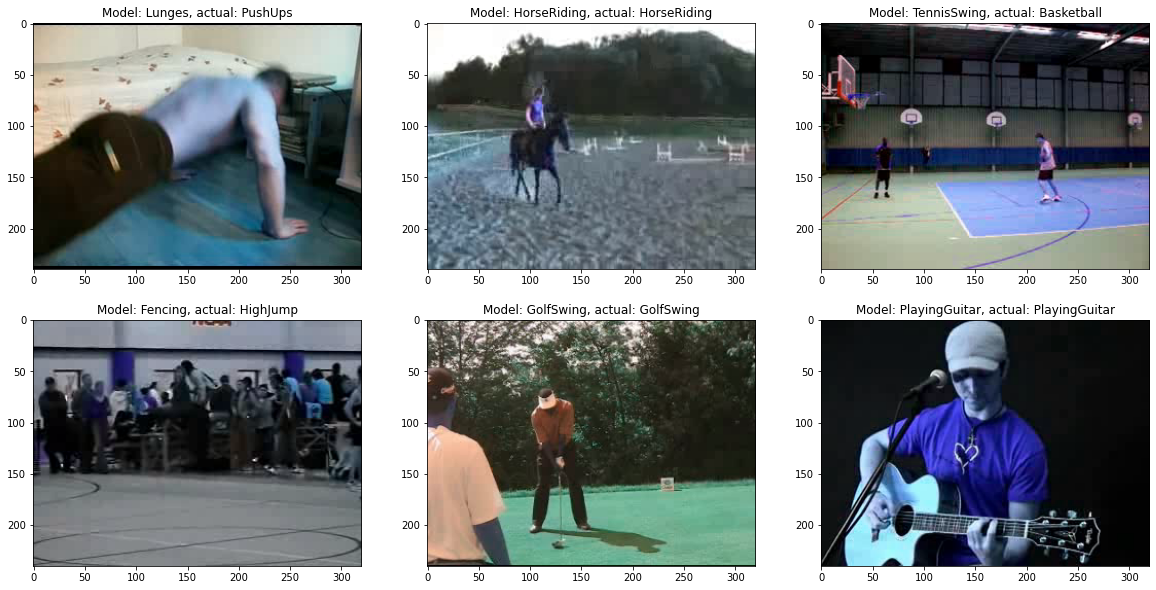

In [ ]:
def get_video_samples(videos_list):
    samples = []
    for path in videos_list:
        vidcap = cv2.VideoCapture(path)
        success, image = vidcap.read()
        samples.append(image)
    return samples

def get_labels(videos_list):
    return [x.split('/')[-1].split('_')[1] for x in videos_list]

def showPredictions(predictions, videos_list):
    df = pd.read_csv('/content/data/classInd.txt', header=None, sep=' ')
    plt.rcParams["figure.figsize"] = (20,10)
    samples = get_video_samples(videos_list)
    labels = get_labels(videos_list)
    fig, axs = plt.subplots(2, 3)
    for i in range(len(samples)):
        axs[i//3, i%3].imshow(samples[i])
        axs[i//3, i%3].set_title(f'Model: {df[1][predictions[i]]}, actual: {labels[i]}')

showPredictions(predictions, video_path_list)